<h1>I. Import library and load dataset 

In [81]:
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings('ignore')

In [82]:
data = pd.read_csv(r"C:\Users\PC\Downloads\Social_Network_Ads.csv")
data

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


In [83]:
data.duplicated().sum()

0

In [84]:
data.describe()

,User ID,Age,EstimatedSalary,Purchased
count,4.000000e+02,400.000000,400.000000,400.000000
mean,1.569154e+07,37.655000,69742.500000,0.357500
std,7.165832e+04,10.482877,34096.960282,0.479864
min,1.556669e+07,18.000000,15000.000000,0.000000
25%,1.562676e+07,29.750000,43000.000000,0.000000
50%,1.569434e+07,37.000000,70000.000000,0.000000
75%,1.575036e+07,46.000000,88000.000000,1.000000
max,1.581524e+07,60.000000,150000.000000,1.000000


In [85]:
data.isnull().sum()

User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

<h1>II. EDA

<h2>1. Gender 

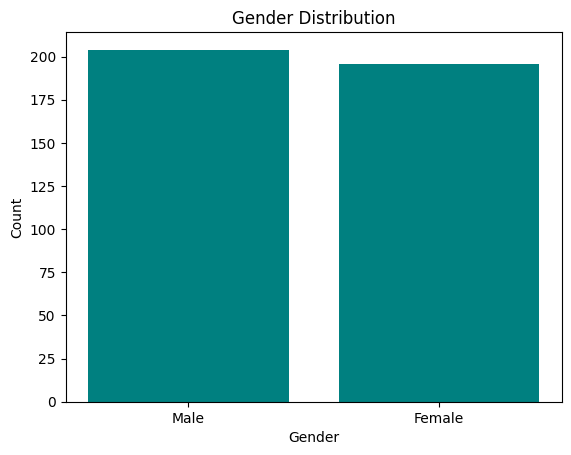

In [86]:
fig, ax = plt.subplots()

ax.bar(data['Gender'].unique(), data['Gender'].value_counts(), color='teal')

ax.set_xlabel('Gender')
ax.set_ylabel('Count')
ax.set_title('Gender Distribution')

plt.show()

<h2>2. Age

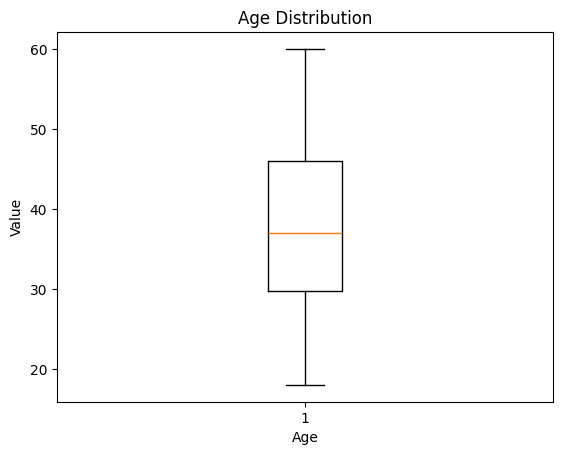

In [87]:
fig, ax = plt.subplots()

ax.boxplot(data['Age'])

ax.set_xlabel('Age')
ax.set_ylabel('Value')
ax.set_title('Age Distribution')

plt.show()

<h2>3. EstimatedSalary

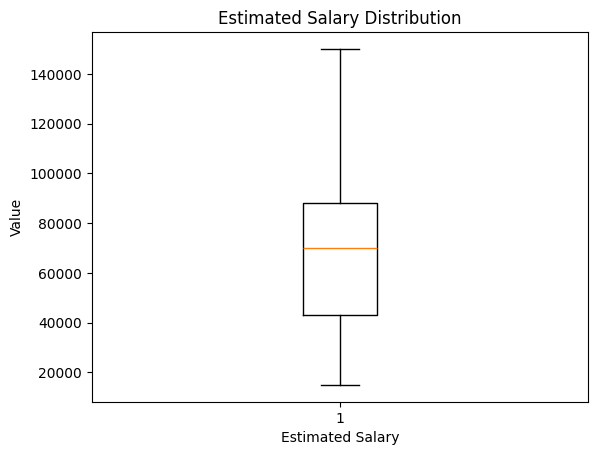

In [88]:
fig, ax = plt.subplots()

ax.boxplot(data['EstimatedSalary'])

ax.set_xlabel('Estimated Salary')
ax.set_ylabel('Value')
ax.set_title('Estimated Salary Distribution')

plt.show()

<h2>4. Target

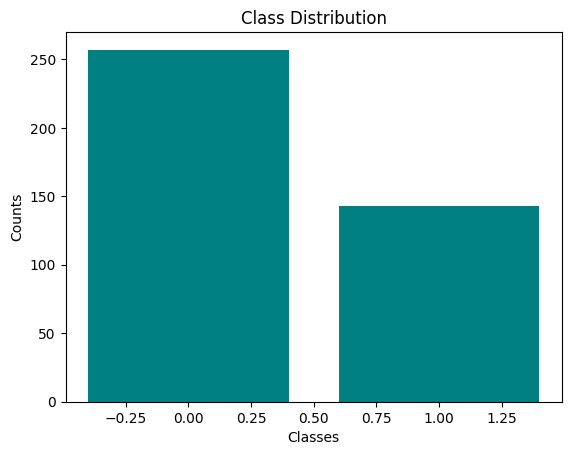

In [89]:
fig, ax = plt.subplots()

ax.bar(data['Purchased'].unique(), data['Purchased'].value_counts(), color='teal')

ax.set_xlabel('Classes')
ax.set_ylabel('Counts')
ax.set_title('Class Distribution')

plt.show()

Overall properties of the dataset:
- No outliers, missing values in all features
- Dataset is already cleaned
- There is a slight imbalance in the target value 
- The value range of features is different

<h1>III. Preprocessing 

<h2>1. Encoding 

In [90]:
encoder = LabelEncoder()
data['Gender'] = encoder.fit_transform(data['Gender'])

In [91]:
data.drop('User ID', axis=1, inplace=True)

In [92]:
data

,Gender,Age,EstimatedSalary,Purchased
0,1,19,19000,0
1,1,35,20000,0
2,0,26,43000,0
3,0,27,57000,0
4,1,19,76000,0
...,...,...,...,...
395,0,46,41000,1
396,1,51,23000,1
397,0,50,20000,1
398,1,36,33000,0


<h1>IV. Models

In [93]:
y = data['Purchased']
X = data.drop('Purchased', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h2>1. Logistic Regression 

In [94]:
pipeline = Pipeline([
    ('model', LogisticRegression(random_state=42))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

test_recall = recall_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print(f"Test Recall score: {test_recall:.4f}")
print(f"Test Precision score: {test_precision:.4f}")
print(f"Test Accuracy score: {test_accuracy:.4f}")
print(f"Test F1 score: {test_f1:.4f}")

recall_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall')
precision_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision')
accuracy_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
f1_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')

print(f"Mean cv Recall score: {recall_scores.mean():.4f}")
print(f"Mean cv Precision score: {precision_scores.mean():.4f}")
print(f"Mean cv Accuracy score: {accuracy_scores.mean():.4f}")
print(f"Mean cv F1 score: {f1_scores.mean():.4f}")


Test Recall score: 0.7500
Test Precision score: 0.9130
Test Accuracy score: 0.8875
Test F1 score: 0.8235
Mean cv Recall score: 0.6348
Mean cv Precision score: 0.8255
Mean cv Accuracy score: 0.8156
Mean cv F1 score: 0.7132


In [95]:
pipeline = Pipeline([
    ('polynomial', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('feature_selection', RFE(estimator=LogisticRegression())),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(random_state=42)),
])

parameter = {
    'polynomial__degree' : [2, 3],
    'feature_selection__n_features_to_select': [5, 10, 15],
    'model__penalty' : ['l1','l2'],
    'model__C' : [0.01, 0.1, 1, 10, 100],
    'model__solver' : ['liblinear', 'lbfgs'],
    'model__max_iter' : [10, 100, 200, 500, 1000]}

grid_search = GridSearchCV(estimator=pipeline, param_grid=parameter, verbose=0,cv=5, scoring='f1')

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_) 
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

y_pred = grid_search.predict(X_test) 
test_accuracy = accuracy_score(y_test, y_pred) 
test_precision = precision_score(y_test, y_pred) 
test_recall = recall_score(y_test, y_pred) 
test_f1 = f1_score(y_test, y_pred) 

print(f"Test Accuracy score: {test_accuracy:.4f}") 
print(f"Test Precision score: {test_precision:.4f}") 
print(f"Test Recall score: {test_recall:.4f}") 
print(f"Test F1 score: {test_f1:.4f}") 

Best parameters found:  {'feature_selection__n_features_to_select': 5, 'model__C': 10, 'model__max_iter': 10, 'model__penalty': 'l1', 'model__solver': 'liblinear', 'polynomial__degree': 3}
Best cross-validation score: 0.8747
Test Accuracy score: 0.9250
Test Precision score: 0.8438
Test Recall score: 0.9643
Test F1 score: 0.9000


Four evaluation metrics are used: accuracy, precision, recall, and f1 score. By combining techniques (polynomial features, feature selection, SMOTE for resampling, hyperparameter tuning), both test scores and cross-validation scores in four metrics are significantly improved. However, two problems have to be considered here: the imbalance of the dataset and GridsearchCV is used to find the best parameters for the F1 score so test scores for other metrics are not precise. Therefore, only F1 score is used throughout this mini project, since it is suitable for this imbalanced dataset and consistency to follow the improvement.

Instead of randomly removing features, the most relevant features are chosen to get the best evaluation score. In this case, there are 5 features.

Results (in F1 score) of diifferent technique combinations:
- model => mean cv: 0.7132; test: 0.8235
- poly + scaler + SMOTE (resampling) + model => mean cv: 0.8448; test: 0.9 
- poly + scaler + feature selection + SMOTE (resampling) + model => mean cv: 0.8654; test: 0.9250 
- poly + scaler + feature selection + SMOTE (resampling) + model + tuning => mean cv: 0.8747; test: 0.9

<h2>2. Decision tree 

In [96]:
pipeline = Pipeline([
    ('model', DecisionTreeClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

test_f1 = f1_score(y_test, y_pred)

print(f"Test F1 score: {test_f1:.4f}")

f1_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')

print(f"Mean cv F1 score: {f1_scores.mean():.4f}")


Test F1 score: 0.7778
Mean cv F1 score: 0.8272


In [97]:
#CART (Classification and Regression Trees)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', DecisionTreeClassifier(random_state=42))
])

parameter = {
    'model__max_depth' : [3, 5, 10, 20, 30],
    'model__min_samples_split' : [2, 5, 10, 20],
    'model__min_samples_leaf' : [1, 2, 5, 10],
    'model__max_features' : ['auto', 'sqrt', 'log2'],
    'model__max_leaf_nodes' : [10, 50, 100],
    'model__ccp_alpha' : [0.0, 0.001, 0.005, 0.01, 0.05, 0.1]}

grid_search = GridSearchCV(estimator=pipeline, param_grid=parameter, verbose=0,cv=5, scoring='f1')

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_.mean()))

test_score = grid_search.score(X_test, y_test)
print("Test set score: {:.4f}".format(test_score))

Best parameters found:  {'model__ccp_alpha': 0.005, 'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__max_leaf_nodes': 50, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5}
Best cross-validation score: 0.8584
Test set score: 0.9000


The standard Decision Tree (CART) algorithm is chosen for decision tree classification because of its simplicity, interpretability, and ease of implementation.

StandardScaler is not strictly necessary for tree-based models because they are not sensitive to the scale of the input features, but it turns out to improve the model result. Therefore only SMOTE and StandardScaler are applied, while other methods may not benefit for Decision Tree.

- model => mean cv: 0.7778; test: 0.8272
- scaler + SMOTE + model + tuning => mean cv: 0.8584; test: 0.9

<h2>3. Random forrest 

In [98]:
pipeline = Pipeline([
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

test_f1 = f1_score(y_test, y_pred)

print(f"Test F1 score: {test_f1:.4f}")

f1_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')

print(f"Mean cv F1 score: {f1_scores.mean():.4f}")


Test F1 score: 0.8621
Mean cv F1 score: 0.8483


In [99]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

parameter = {
    'model__n_estimators' : [25, 50, 100, 150],
    'model__max_features' : ['sqrt', 'log2', None],
    'model__max_depth' : [3, 6, 9],
    'model__max_leaf_nodes' : [3, 6, 9],
    'model__max_samples' : [0.5,0.75,1],
    'model__min_samples_split' : [2,4,6],
    "model__bootstrap": [True, False],
    "model__oob_score": [True, False]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=parameter, verbose=0,cv=5, scoring='f1')

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_.mean()))

test_score = grid_search.score(X_test, y_test)
print("Test set score: {:.4f}".format(test_score))

Best parameters found:  {'model__bootstrap': True, 'model__max_depth': 3, 'model__max_features': None, 'model__max_leaf_nodes': 6, 'model__max_samples': 0.5, 'model__min_samples_split': 2, 'model__n_estimators': 100, 'model__oob_score': True}
Best cross-validation score: 0.8863
Test set score: 0.9000


- model => mean cv: 0.8483; test: 0.8621
- SMOTE + model => mean cv: 0.8516; test: 0.9125
- scaler + SMOTE + model + tuning => mean cv: 0.8863; test: 0.9

<h2>4. Neural network

In [102]:
smote = SMOTE(random_state=42) 
X_res, y_res = smote.fit_resample(X, y)

scaler = StandardScaler() 
X_res = scaler.fit_transform(X_res)

X_res = torch.tensor(X_res, dtype=torch.float32) 
y_res = torch.tensor(y_res, dtype=torch.float32).view(-1, 1) 

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


model = DNN()

criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

num_epochs = 10

for epoch in range(num_epochs):
    model.train() 
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval() 

all_preds = []
all_labels = []

with torch.no_grad(): 
    total_acc = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        preds = (outputs > 0.5).float() 
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

F1 = f1_score(all_labels, all_preds, average='binary')
print(f"Test F1 Score: {F1:.4f}")

Epoch [1/10], Loss: 0.7612
Epoch [2/10], Loss: 0.7109
Epoch [3/10], Loss: 0.6828
Epoch [4/10], Loss: 0.6698
Epoch [5/10], Loss: 0.6865
Epoch [6/10], Loss: 0.6201
Epoch [7/10], Loss: 0.6137
Epoch [8/10], Loss: 0.6530
Epoch [9/10], Loss: 0.5709
Epoch [10/10], Loss: 0.5794
Test F1 Score: 0.8247


- scaler + SMOTE + model => test: 0.8247